In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from scipy.stats import ttest_ind
from scipy.stats import zscore
from scipy.stats.mstats import winsorize
from sqlalchemy import create_engine
import warnings

from scipy.stats import jarque_bera
from scipy.stats import normaltest
from scipy.stats import boxcox
from sklearn.preprocessing import normalize
from sklearn.preprocessing import scale

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import power_transform
from sklearn.preprocessing import quantile_transform


warnings.filterwarnings('ignore')
sns.set(style="whitegrid")


In [2]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'lifeexpectancy'
table_name = 'lifeexpectancy'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
                       
life_expectancy = pd.read_sql_query('select * from lifeexpectancy',con=engine)

engine.dispose()

In [3]:
# make list easier to deal with
life_expectancy.columns = life_expectancy.columns.str.strip()
life_expectancy.columns = life_expectancy.columns.str.lower()
life_expectancy.columns = life_expectancy.columns.str.replace(' ', '_')
life_expectancy.columns = life_expectancy.columns.str.replace('-', '_')
life_expectancy.rename(columns={'thinness__1_19_years': 'thinness_1to19_years',
                                'thinness_5_9_years': 'thinness_5to9_years'}, inplace=True)
column_list = list(life_expectancy.columns)
non_object_list = list(life_expectancy.select_dtypes(exclude=['object']))

fill_list = ['life_expectancy',
             'adult_mortality',
             'infant_deaths',
             'alcohol',
             'percentage_expenditure',
             'hepatitis_b', 
             'measles',
             'bmi',
             'under_five_deaths',
             'polio',
             'total_expenditure',
             'diphtheria',
             'hiv/aids',
             'gdp',
             'population',
             'thinness_1to19_years',
             'thinness_5to9_years',
             'income_composition_of_resources',
             'schooling']

In [4]:
display(life_expectancy.head(5))
display(life_expectancy.sample(5))

print(life_expectancy.describe())
print(life_expectancy.isnull().sum())

,country,year,status,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,...,polio,total_expenditure,diphtheria,hiv/aids,gdp,population,thinness_1to19_years,thinness_5to9_years,income_composition_of_resources,schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


,country,year,status,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,...,polio,total_expenditure,diphtheria,hiv/aids,gdp,population,thinness_1to19_years,thinness_5to9_years,income_composition_of_resources,schooling
1288,Italy,2010,Developed,81.8,6.0,2,6.95,5219.668802,96.0,372,...,96.0,9.42,96.0,0.1,35849.373640,59277417.0,0.5,0.5,0.869,16.4
400,Bulgaria,2000,Developed,71.1,163.0,1,9.69,15.235727,94.0,46,...,94.0,6.70,93.0,0.1,169.285860,817172.0,2.5,2.5,0.709,12.9
2834,Uzbekistan,2007,Developing,67.8,184.0,22,2.15,9.290984,99.0,863,...,98.0,5.81,96.0,0.3,83.476942,26868.0,3.1,3.1,0.631,11.8
1375,Kenya,2003,Developing,52.4,437.0,74,1.49,35.852047,73.0,65,...,75.0,4.45,73.0,14.5,436.687536,3413852.0,8.8,8.8,0.450,8.2
2713,Tuvalu,2013,Developing,NaN,NaN,0,0.01,78.281203,9.0,0,...,9.0,16.61,9.0,0.1,3542.135890,1819.0,0.2,0.1,NaN,0.0


              year  life_expectancy  adult_mortality  infant_deaths  \
count  2938.000000      2928.000000      2928.000000    2938.000000   
mean   2007.518720        69.224932       164.796448      30.303948   
std       4.613841         9.523867       124.292079     117.926501   
min    2000.000000        36.300000         1.000000       0.000000   
25%    2004.000000        63.100000        74.000000       0.000000   
50%    2008.000000        72.100000       144.000000       3.000000   
75%    2012.000000        75.700000       228.000000      22.000000   
max    2015.000000        89.000000       723.000000    1800.000000   

           alcohol  percentage_expenditure  hepatitis_b        measles  \
count  2744.000000             2938.000000  2385.000000    2938.000000   
mean      4.602861              738.251295    80.940461    2419.592240   
std       4.052413             1987.914858    25.070016   11467.272489   
min       0.010000                0.000000     1.000000       0.

In [5]:
# because it is over time I think interpolation will work best
fill_list = ['life_expectancy',
             'adult_mortality',
             'infant_deaths',
             'alcohol',
             'percentage_expenditure',
             'hepatitis_b', 
             'measles',
             'bmi',
             'under_five_deaths',
             'polio',
             'total_expenditure',
             'diphtheria',
             'hiv/aids',
             'gdp',
             'population',
             'thinness_1to19_years',
             'thinness_5to9_years',
             'income_composition_of_resources',
             'schooling']

life_expectancy2 = life_expectancy.copy()


for col in fill_list:
    life_expectancy2[col].interpolate(inplace=True)

In [6]:
print(life_expectancy2.isnull().sum())

country                            0
year                               0
status                             0
life_expectancy                    0
adult_mortality                    0
infant_deaths                      0
alcohol                            0
percentage_expenditure             0
hepatitis_b                        0
measles                            0
bmi                                0
under_five_deaths                  0
polio                              0
total_expenditure                  0
diphtheria                         0
hiv/aids                           0
gdp                                0
population                         0
thinness_1to19_years               0
thinness_5to9_years                0
income_composition_of_resources    0
schooling                          0
dtype: int64


In [7]:
len(life_expectancy2)

2938

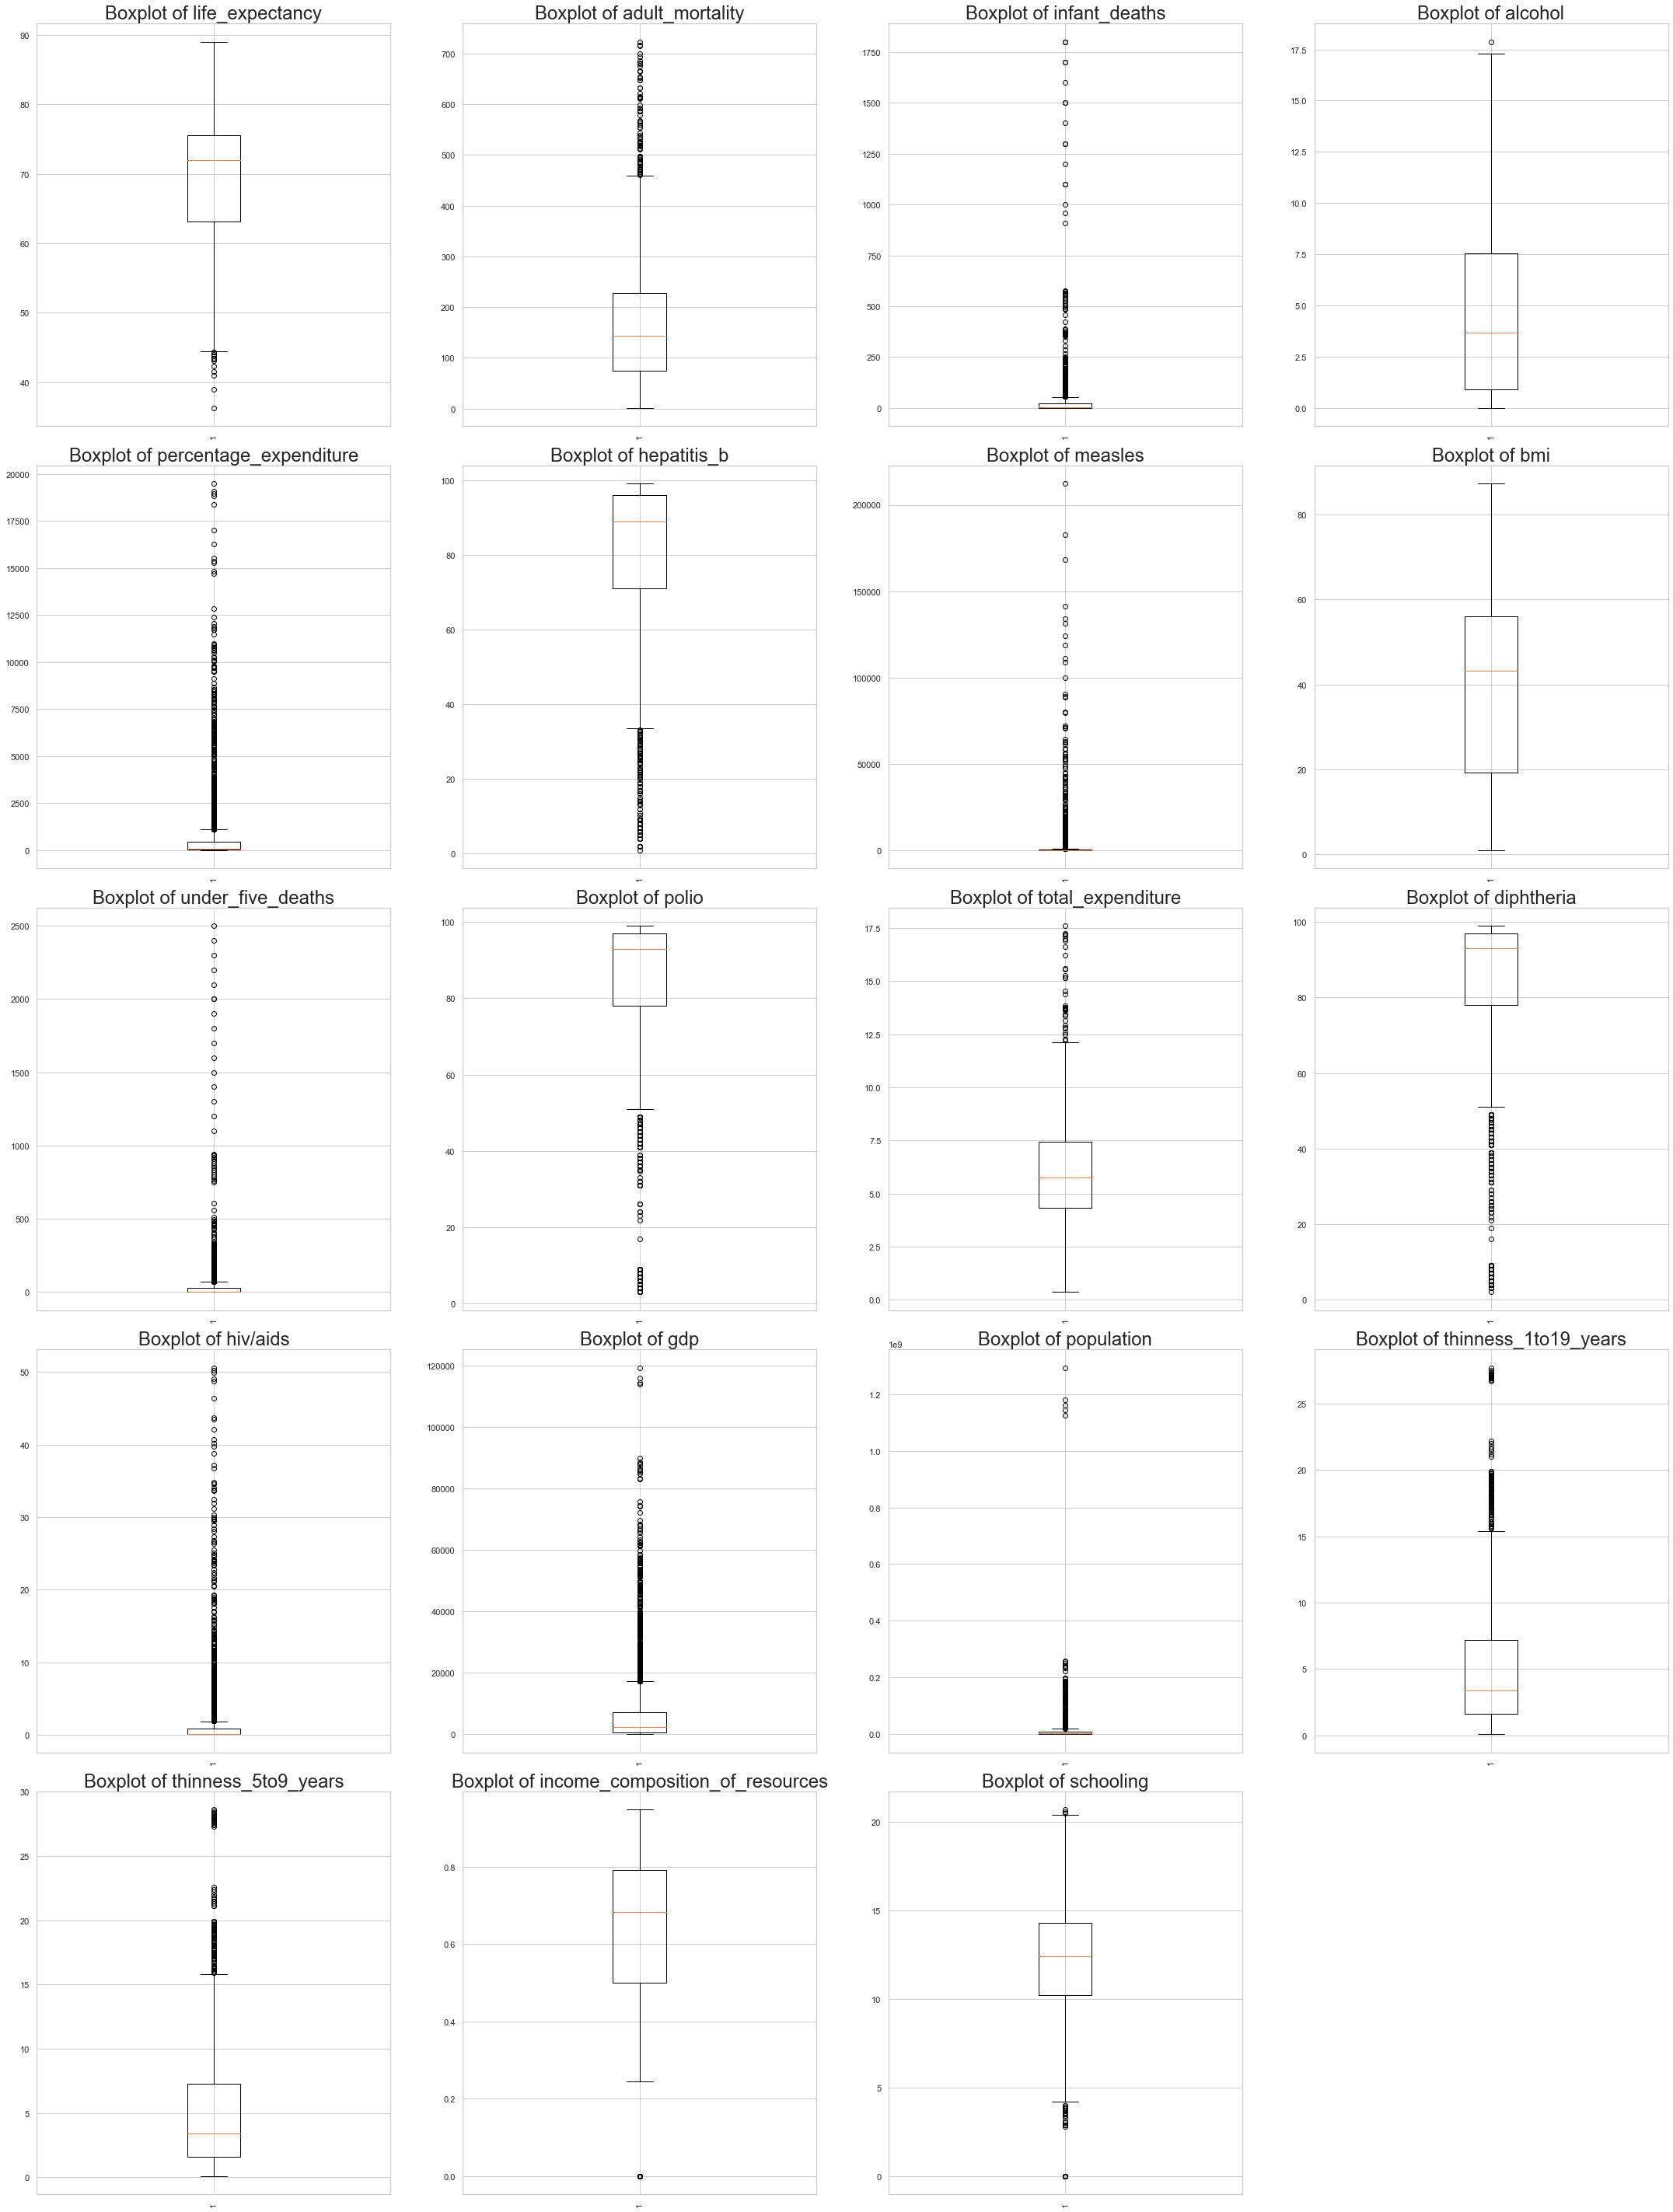

In [8]:
#taking stock of outliers visually
fig = plt.figure(figsize=(30,150))

for i, col in enumerate(fill_list):
    
    plt.subplot(len(fill_list), 4, i+1)
    plt.boxplot(life_expectancy2[col])
    plt.xticks(rotation='vertical')
    plt.title("Boxplot of {}".format(col), fontsize=24)
    
plt.tight_layout()
plt.show()

In [9]:
for col in fill_list:
    q75, q25 = np.percentile(life_expectancy2[col], [75 ,25])
    iqr = q75 - q25

    min_val = q25 - (iqr*1.5)
    max_val = q75 + (iqr*1.5)
    print("Number of outliers and percentage of it in {} : {} and %{}".format(col,
                                                                             len((np.where((life_expectancy2[col] > max_val) | 
                                                                                           (life_expectancy2[col] < min_val))[0])),len((np.where((life_expectancy2[col] > max_val) | 
                                                                                           (life_expectancy2[col] < min_val))[0]))*100/2938))
    print('-' * 40)
    print('Percent of outliers high')
    print(len(np.where(life_expectancy2[col] > max_val)[0]) /2938)
    print('Percent of outliers low')
    print(len(np.where(life_expectancy2[col] < min_val)[0]) /2938)

Number of outliers and percentage of it in life_expectancy : 12 and %0.4084411164057182
----------------------------------------
Percent of outliers high
0.0
Percent of outliers low
0.0040844111640571815
Number of outliers and percentage of it in adult_mortality : 82 and %2.791014295439074
----------------------------------------
Percent of outliers high
0.027910142954390742
Percent of outliers low
0.0
Number of outliers and percentage of it in infant_deaths : 315 and %10.721579305650103
----------------------------------------
Percent of outliers high
0.10721579305650102
Percent of outliers low
0.0
Number of outliers and percentage of it in alcohol : 1 and %0.03403675970047652
----------------------------------------
Percent of outliers high
0.0003403675970047651
Percent of outliers low
0.0
Number of outliers and percentage of it in percentage_expenditure : 389 and %13.240299523485364
----------------------------------------
Percent of outliers high
0.13240299523485363
Percent of outl

taking a look at our data we can see a number of outliers. Some columns containing more than others. 

In [10]:
winsorized_list = ['winsorized_life_expectancy',
                   'winsorized_adult_mortality',
                   'winsorized_infant_deaths',
                   'winsorized_alcohol',
                   'winsorized_percentage_expenditure',
                   'winsorized_hepatitis_b',
                   'winsorized_measles',
                   'bmi',
                   'winsorized_under_five_deaths',
                   'winsorized_total_expenditure',
                   'winsorized_diphtheria',
                   'winsorized_hiv/aids',
                   'winsorized_gdp',
                   'winsorized_population',
                   'winsorized_thinness_1to19_years',
                   'winsorized_thinness_5to9_years',
                   'winsorized_income_composition_of_resources',
                   'winsorized_schooling']

life_expectancy2['winsorized_life_expectancy'] = winsorize(
    life_expectancy2['life_expectancy'], (0.005, 0))

life_expectancy2['winsorized_adult_mortality'] = winsorize(
    life_expectancy2['life_expectancy'], (0.01, 0.028))

life_expectancy2['winsorized_infant_deaths'] = winsorize(
    life_expectancy2['infant_deaths'], (0, 0.1073))

life_expectancy2['winsorized_alcohol'] = winsorize(
    life_expectancy2['alcohol'], (0, 0.0004))

life_expectancy2['winsorized_percentage_expenditure'] = winsorize(
    life_expectancy2['percentage_expenditure'], (0, 0.1325))

life_expectancy2['winsorized_hepatitis_b'] = winsorize(
    life_expectancy2['hepatitis_b'], (0.0845, 0))

life_expectancy2['winsorized_measles'] = winsorize(
    life_expectancy2['measles'], (0, 0.1845))

life_expectancy2['winsorized_under_five_deaths'] = winsorize(
    life_expectancy2['under_five_deaths'], (0, 0.1342))

life_expectancy2['winsorized_total_expenditure'] = winsorize(
    life_expectancy2['total_expenditure'], (0, 0.012))

life_expectancy2['winsorized_diphtheria'] = winsorize(
    life_expectancy2['diphtheria'], (0.1025, 0))

life_expectancy2['winsorized_hiv/aids'] = winsorize(
    life_expectancy2['hiv/aids'], (0, 0.185))

life_expectancy2['winsorized_gdp'] = winsorize(
    life_expectancy2['gdp'], (0, 0.1188))

life_expectancy2['winsorized_population'] = winsorize(
    life_expectancy2['population'], (0, 0.1243))

life_expectancy2['winsorized_thinness_1to19_years'] = winsorize(
    life_expectancy2['thinness_1to19_years'], (0, 0.0303))

life_expectancy2['winsorized_thinness_5to9_years'] = winsorize(
    life_expectancy2['thinness_5to9_years'], (0, 0.0331))

life_expectancy2['winsorized_income_composition_of_resources'] = winsorize(
    life_expectancy2['income_composition_of_resources'], (0.0443, 0))

life_expectancy2['winsorized_schooling'] = winsorize(
    life_expectancy2['schooling'], (0.0171, 0.0011))






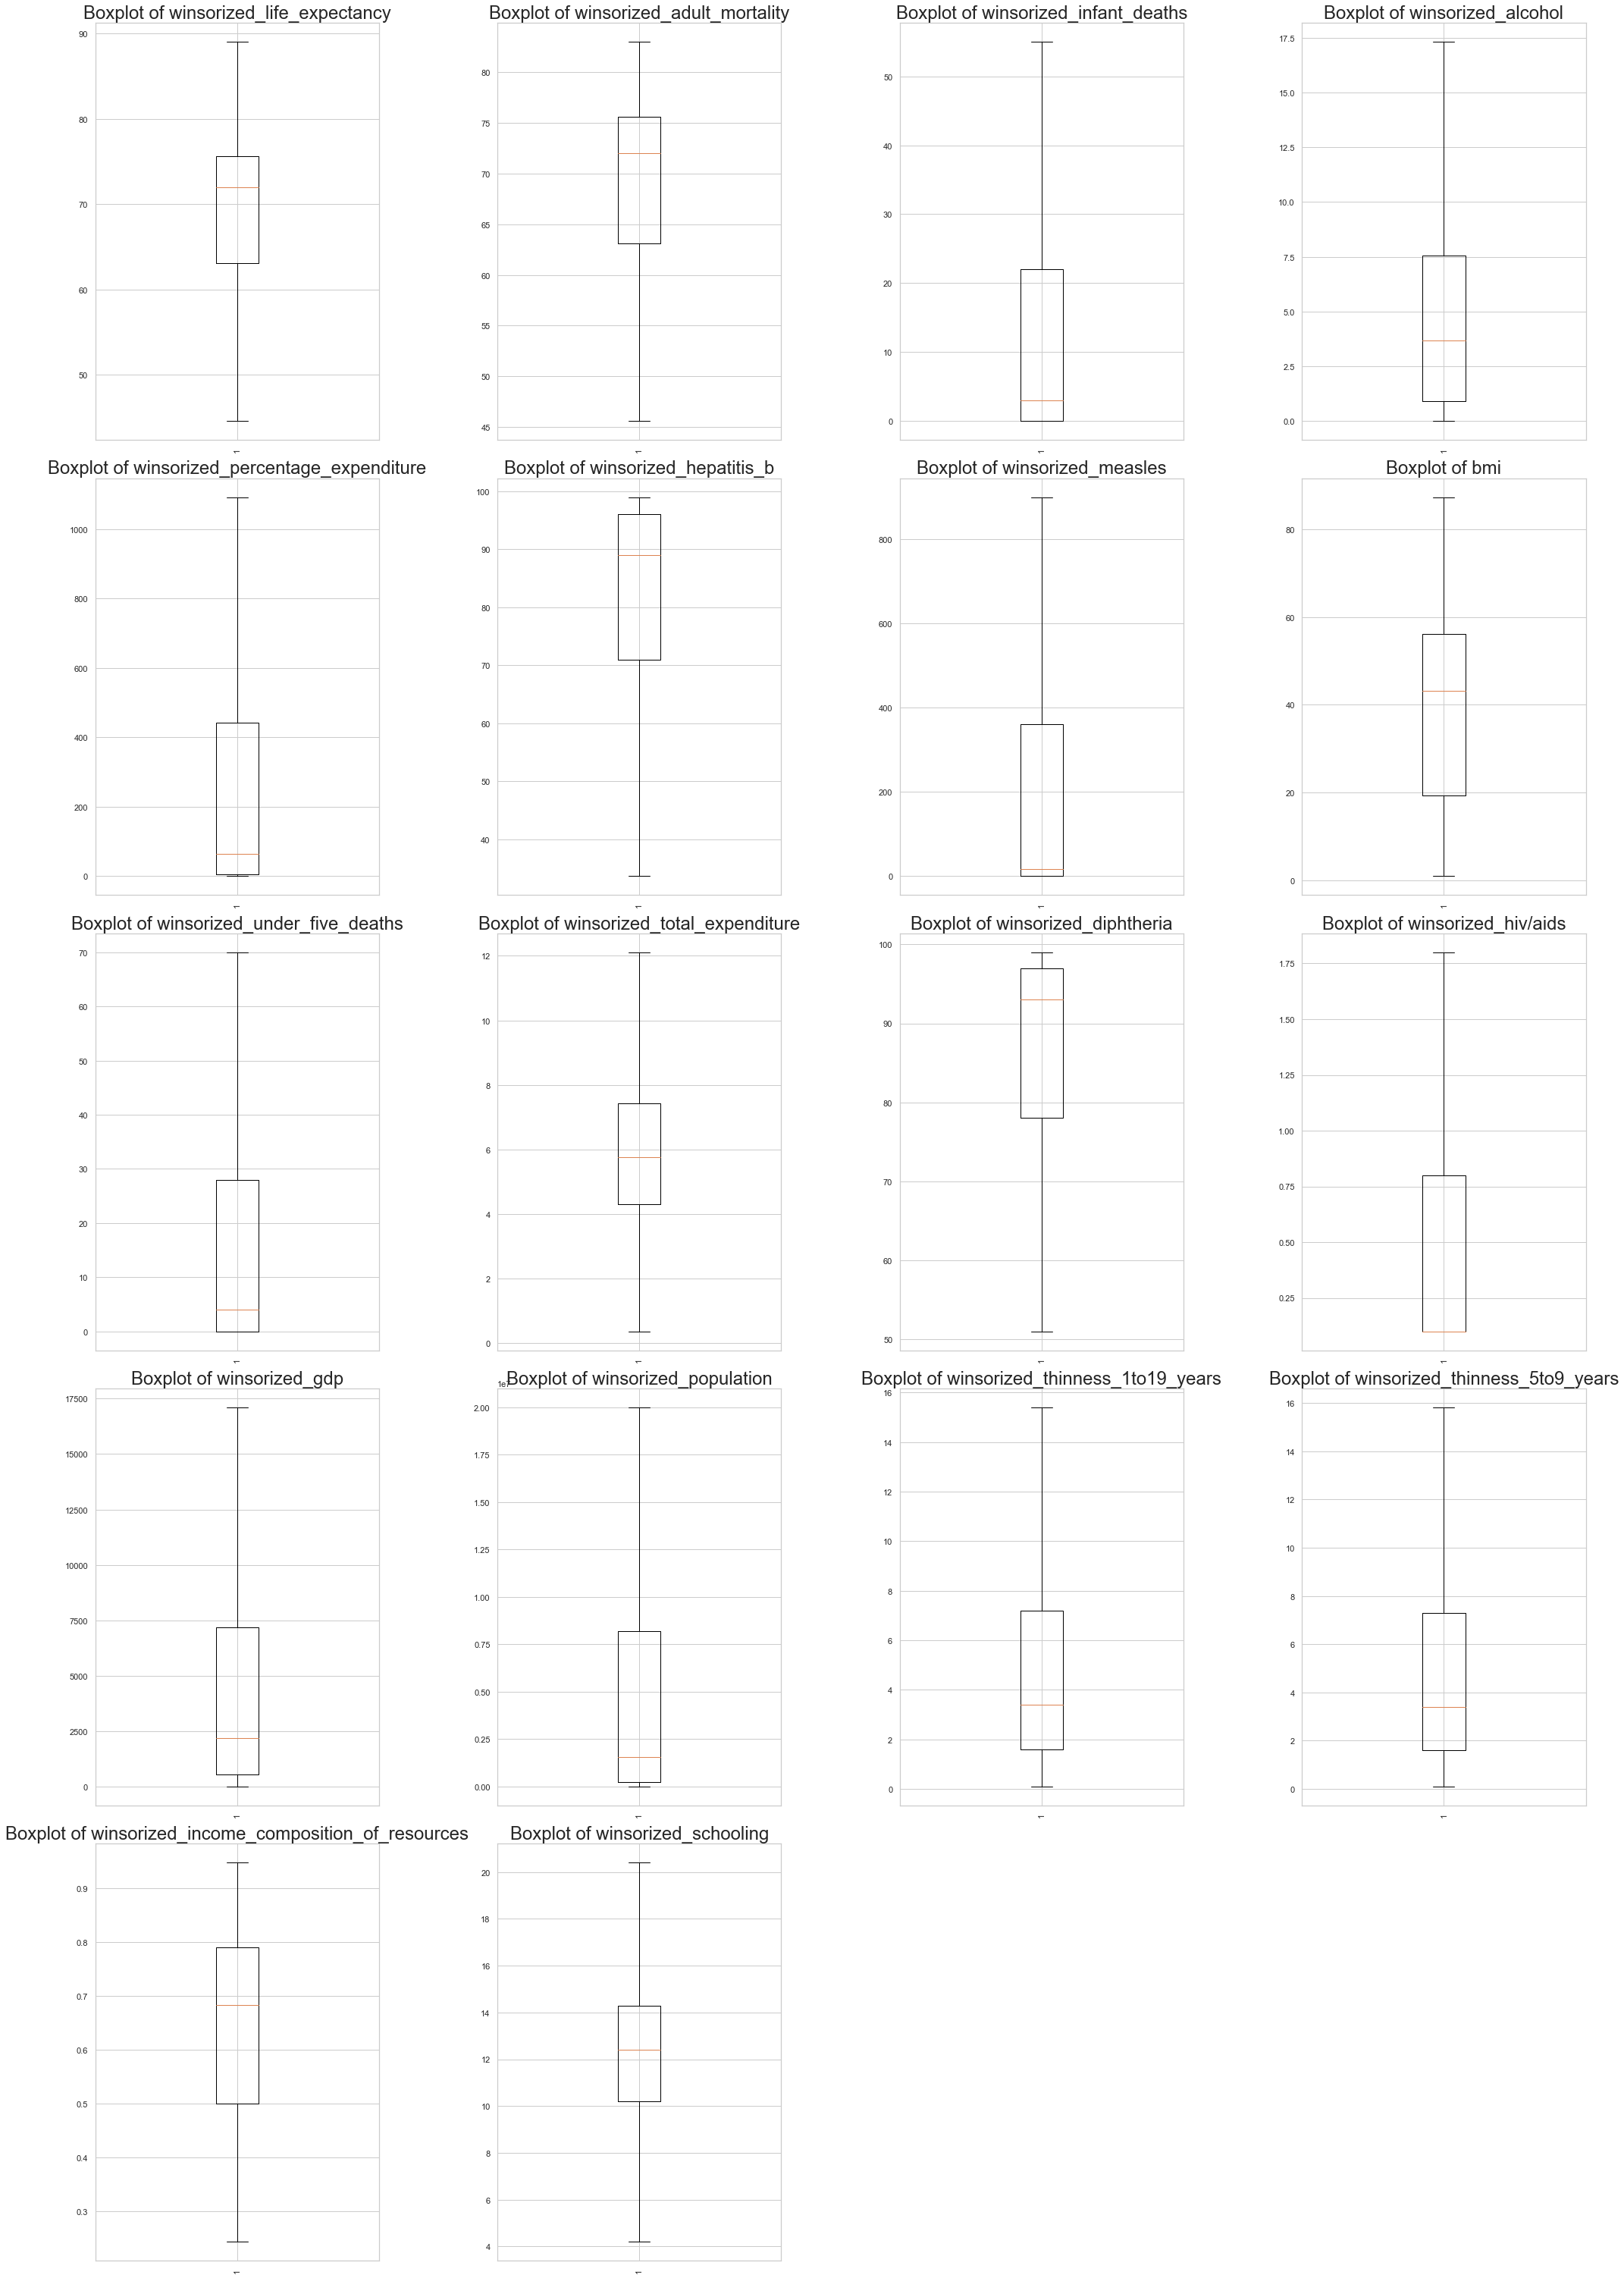

In [11]:
#taking stock of outliers visually
fig = plt.figure(figsize=(30,150))

for i, col in enumerate(winsorized_list):
    
    plt.subplot(len(winsorized_list), 4, i+1)
    plt.boxplot(life_expectancy2[col])
    plt.xticks(rotation='vertical')
    plt.title("Boxplot of {}".format(col), fontsize=24)
    
plt.tight_layout()
plt.show()

In [12]:
for col in winsorized_list:
    q75, q25 = np.percentile(life_expectancy2[col], [75 ,25])
    iqr = q75 - q25

    min_val = q25 - (iqr*1.5)
    max_val = q75 + (iqr*1.5)
    print("Number of outliers and percentage of it in {} : {} and %{}".format(col,
                                                                             len((np.where((life_expectancy2[col] > max_val) | 
                                                                                           (life_expectancy2[col] < min_val))[0])),len((np.where((life_expectancy2[col] > max_val) | 
                                                                                           (life_expectancy2[col] < min_val))[0]))*100/2938))
    print('-' * 40)

Number of outliers and percentage of it in winsorized_life_expectancy : 0 and %0.0
----------------------------------------
Number of outliers and percentage of it in winsorized_adult_mortality : 0 and %0.0
----------------------------------------
Number of outliers and percentage of it in winsorized_infant_deaths : 0 and %0.0
----------------------------------------
Number of outliers and percentage of it in winsorized_alcohol : 0 and %0.0
----------------------------------------
Number of outliers and percentage of it in winsorized_percentage_expenditure : 0 and %0.0
----------------------------------------
Number of outliers and percentage of it in winsorized_hepatitis_b : 0 and %0.0
----------------------------------------
Number of outliers and percentage of it in winsorized_measles : 0 and %0.0
----------------------------------------
Number of outliers and percentage of it in bmi : 0 and %0.0
----------------------------------------
Number of outliers and percentage of it in win

Now that we've dealt with null values and dropped the outliers, it's time to look at the continuous variables.

In [13]:
life_expectancy2.describe()

,year,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,bmi,under_five_deaths,...,winsorized_under_five_deaths,winsorized_total_expenditure,winsorized_diphtheria,winsorized_hiv/aids,winsorized_gdp,winsorized_population,winsorized_thinness_1to19_years,winsorized_thinness_5to9_years,winsorized_income_composition_of_resources,winsorized_schooling
count,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.00000,2938.000000,...,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2.938000e+03,2938.000000,2938.000000,2938.000000,2938.000000
mean,2007.518720,69.214874,164.744554,30.303948,4.548919,738.251295,78.536419,2419.592240,38.29869,42.035739,...,17.965963,5.912047,85.323641,0.526991,4947.913369,5.385886e+06,4.749592,4.780274,0.645255,12.122209
std,4.613841,9.510819,124.226596,117.926501,3.994854,1987.914858,25.177963,11467.272489,19.99140,160.445548,...,25.194515,2.349277,15.504925,0.675962,5849.346636,7.013147e+06,3.979576,4.047285,0.180929,3.205192
min,2000.000000,36.300000,1.000000,0.000000,0.010000,0.000000,1.000000,0.000000,1.00000,0.000000,...,0.000000,0.370000,51.000000,0.100000,1.681350,3.400000e+01,0.100000,0.100000,0.244000,4.200000
25%,2004.000000,63.100000,74.000000,0.000000,0.902500,4.685343,71.000000,0.000000,19.32500,0.000000,...,0.000000,4.312500,78.000000,0.100000,553.618620,2.536025e+05,1.600000,1.600000,0.500000,10.200000
50%,2008.000000,72.000000,144.000000,3.000000,3.697500,64.912906,89.000000,17.000000,43.25000,4.000000,...,4.000000,5.760000,93.000000,0.100000,2192.681084,1.576319e+06,3.400000,3.400000,0.684000,12.400000
75%,2012.000000,75.600000,228.000000,22.000000,7.550000,441.534144,96.000000,360.250000,56.10000,28.000000,...,28.000000,7.440000,97.000000,0.800000,7183.381694,8.215738e+06,7.200000,7.300000,0.791107,14.300000
max,2015.000000,89.000000,723.000000,1800.000000,17.870000,19479.911610,99.000000,212183.000000,87.30000,2500.000000,...,70.000000,12.110000,99.000000,1.800000,17101.347702,1.999647e+07,15.400000,15.817647,0.948000,20.400000


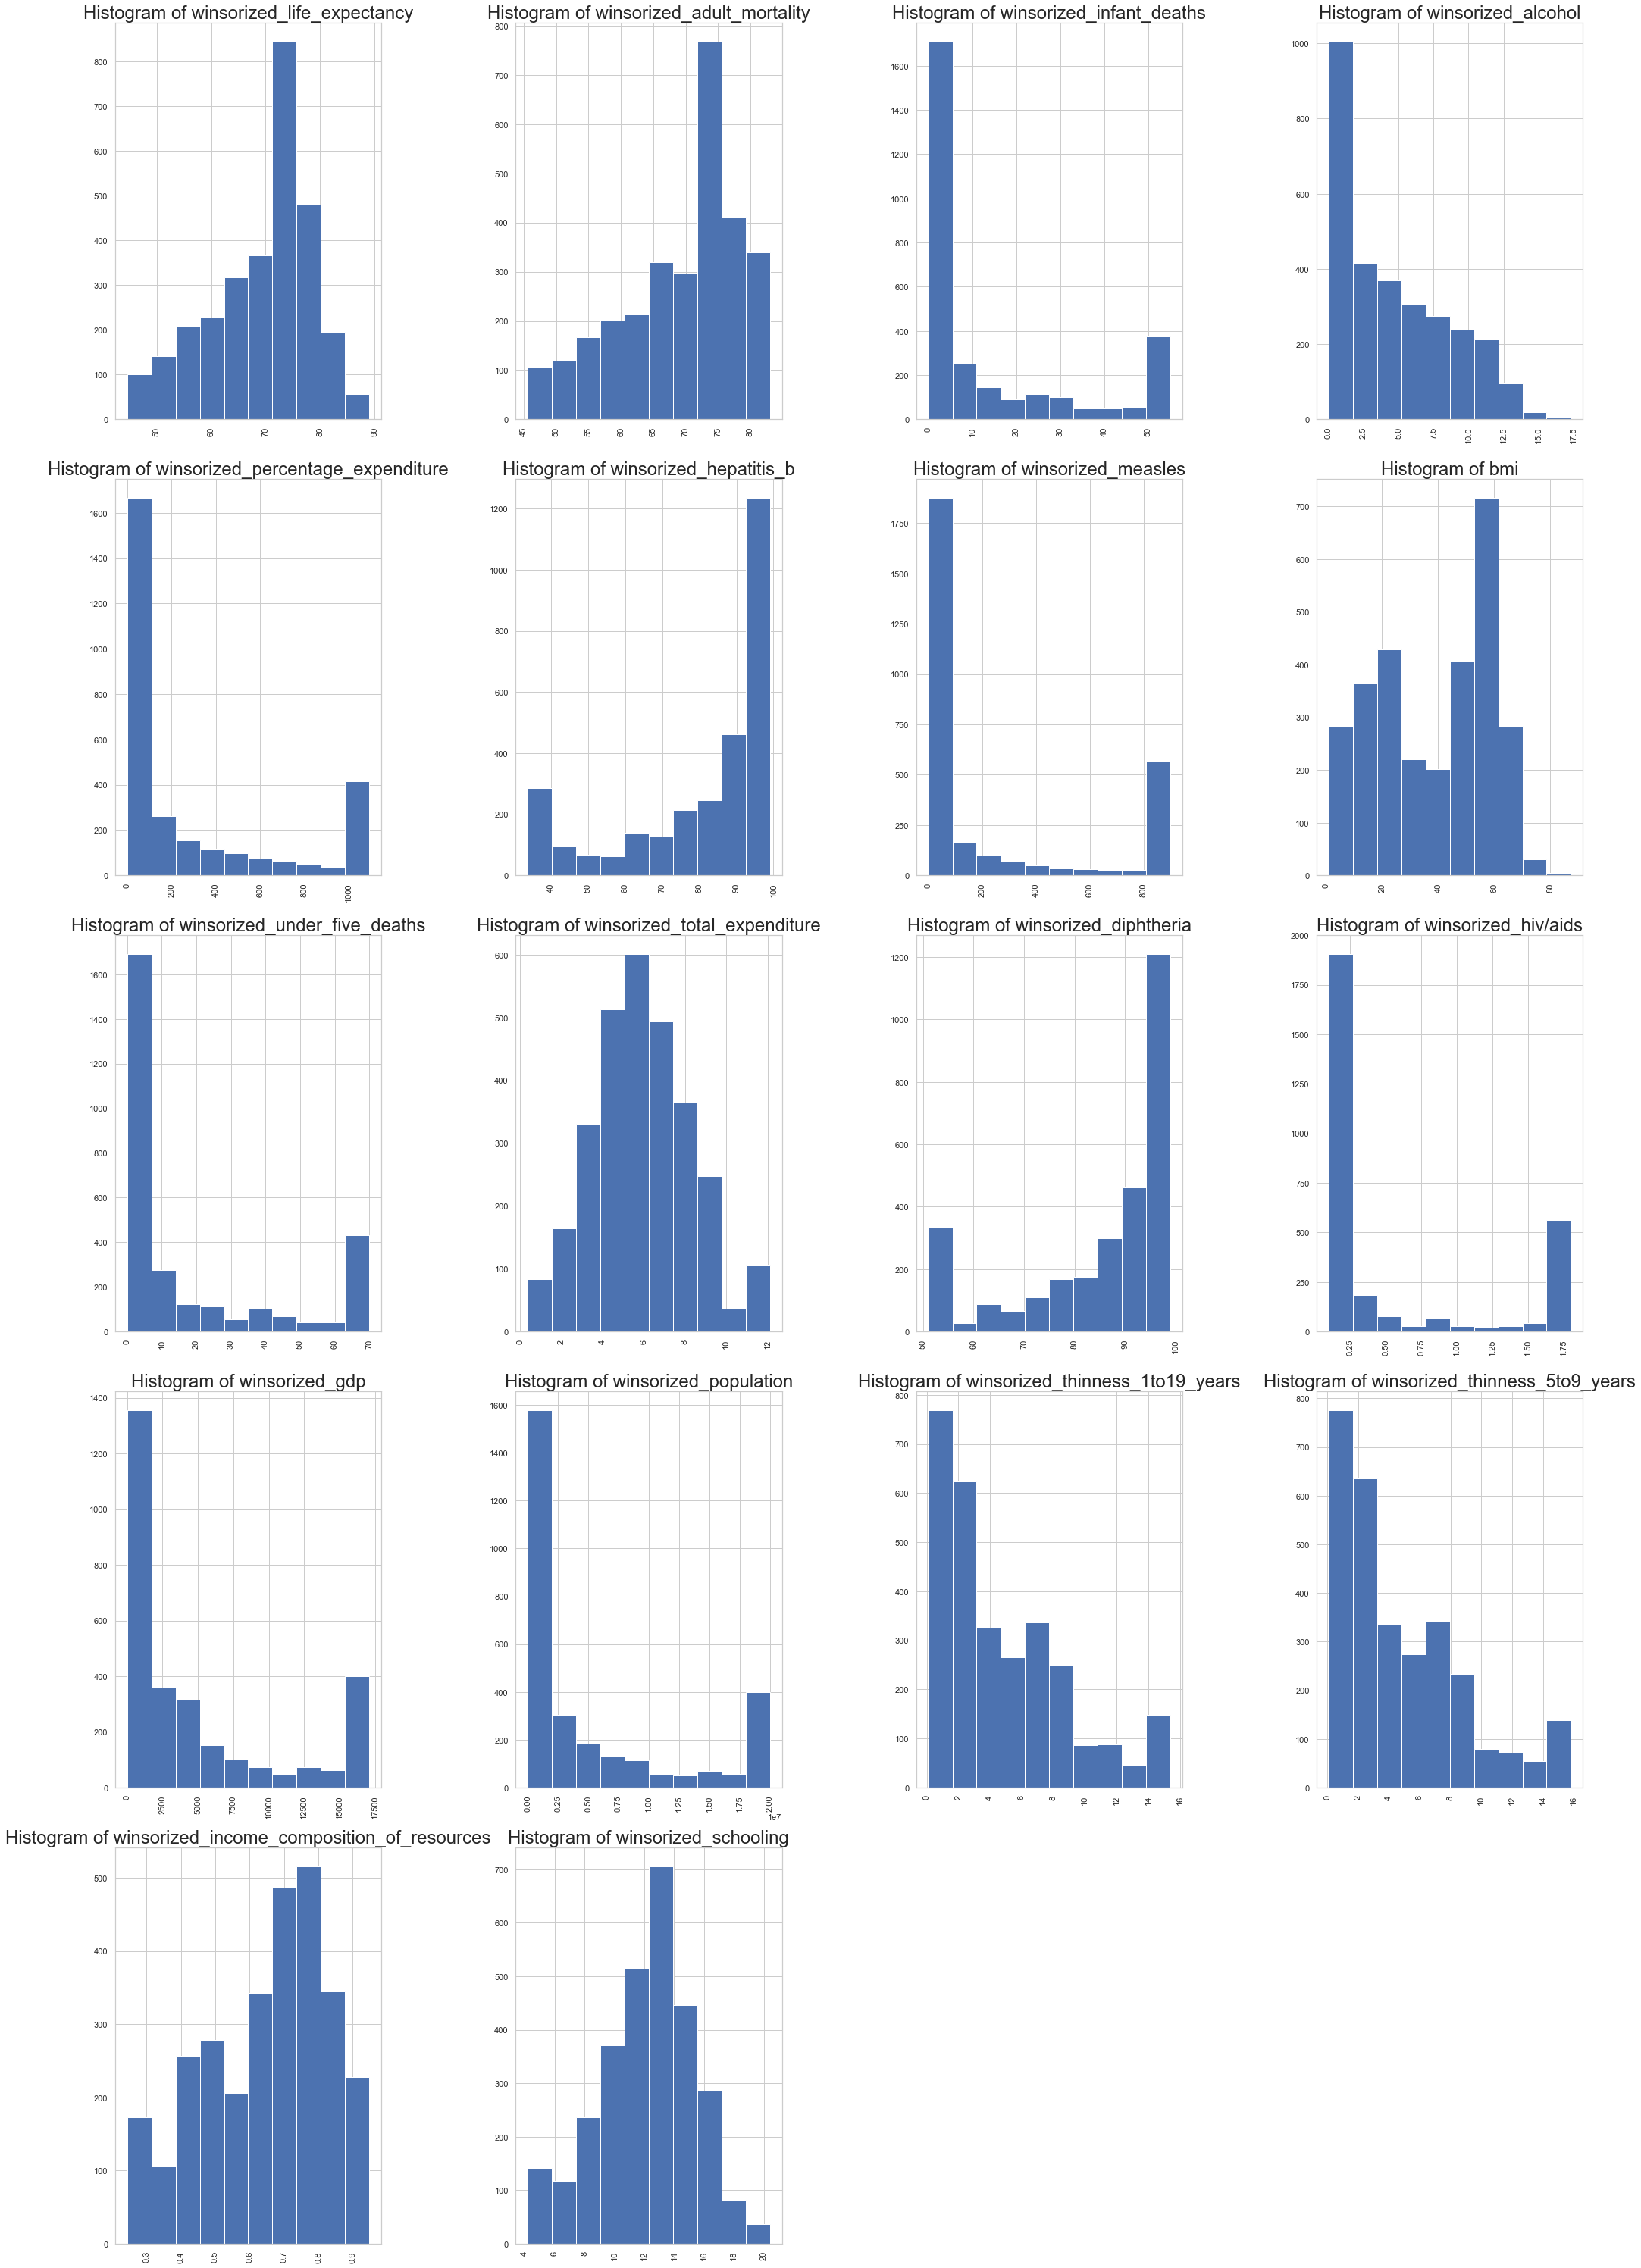

In [14]:
#taking stock of outliers visually
fig = plt.figure(figsize=(30,150))

for i, col in enumerate(winsorized_list):
    
    plt.subplot(len(winsorized_list), 4, i+1)
    plt.hist(life_expectancy2[col])
    plt.xticks(rotation='vertical')
    plt.title("Histogram of {}".format(col), fontsize=24)
    
plt.tight_layout()
plt.show()

A few of our variables look to have relatively normal distributions. Especially schooling, total expenditure, and life expectancy.

it appears that some variables are somewhat normally distributed. Let's see what kind of relationship we have with life expectancy and the rest of our continuous variables.

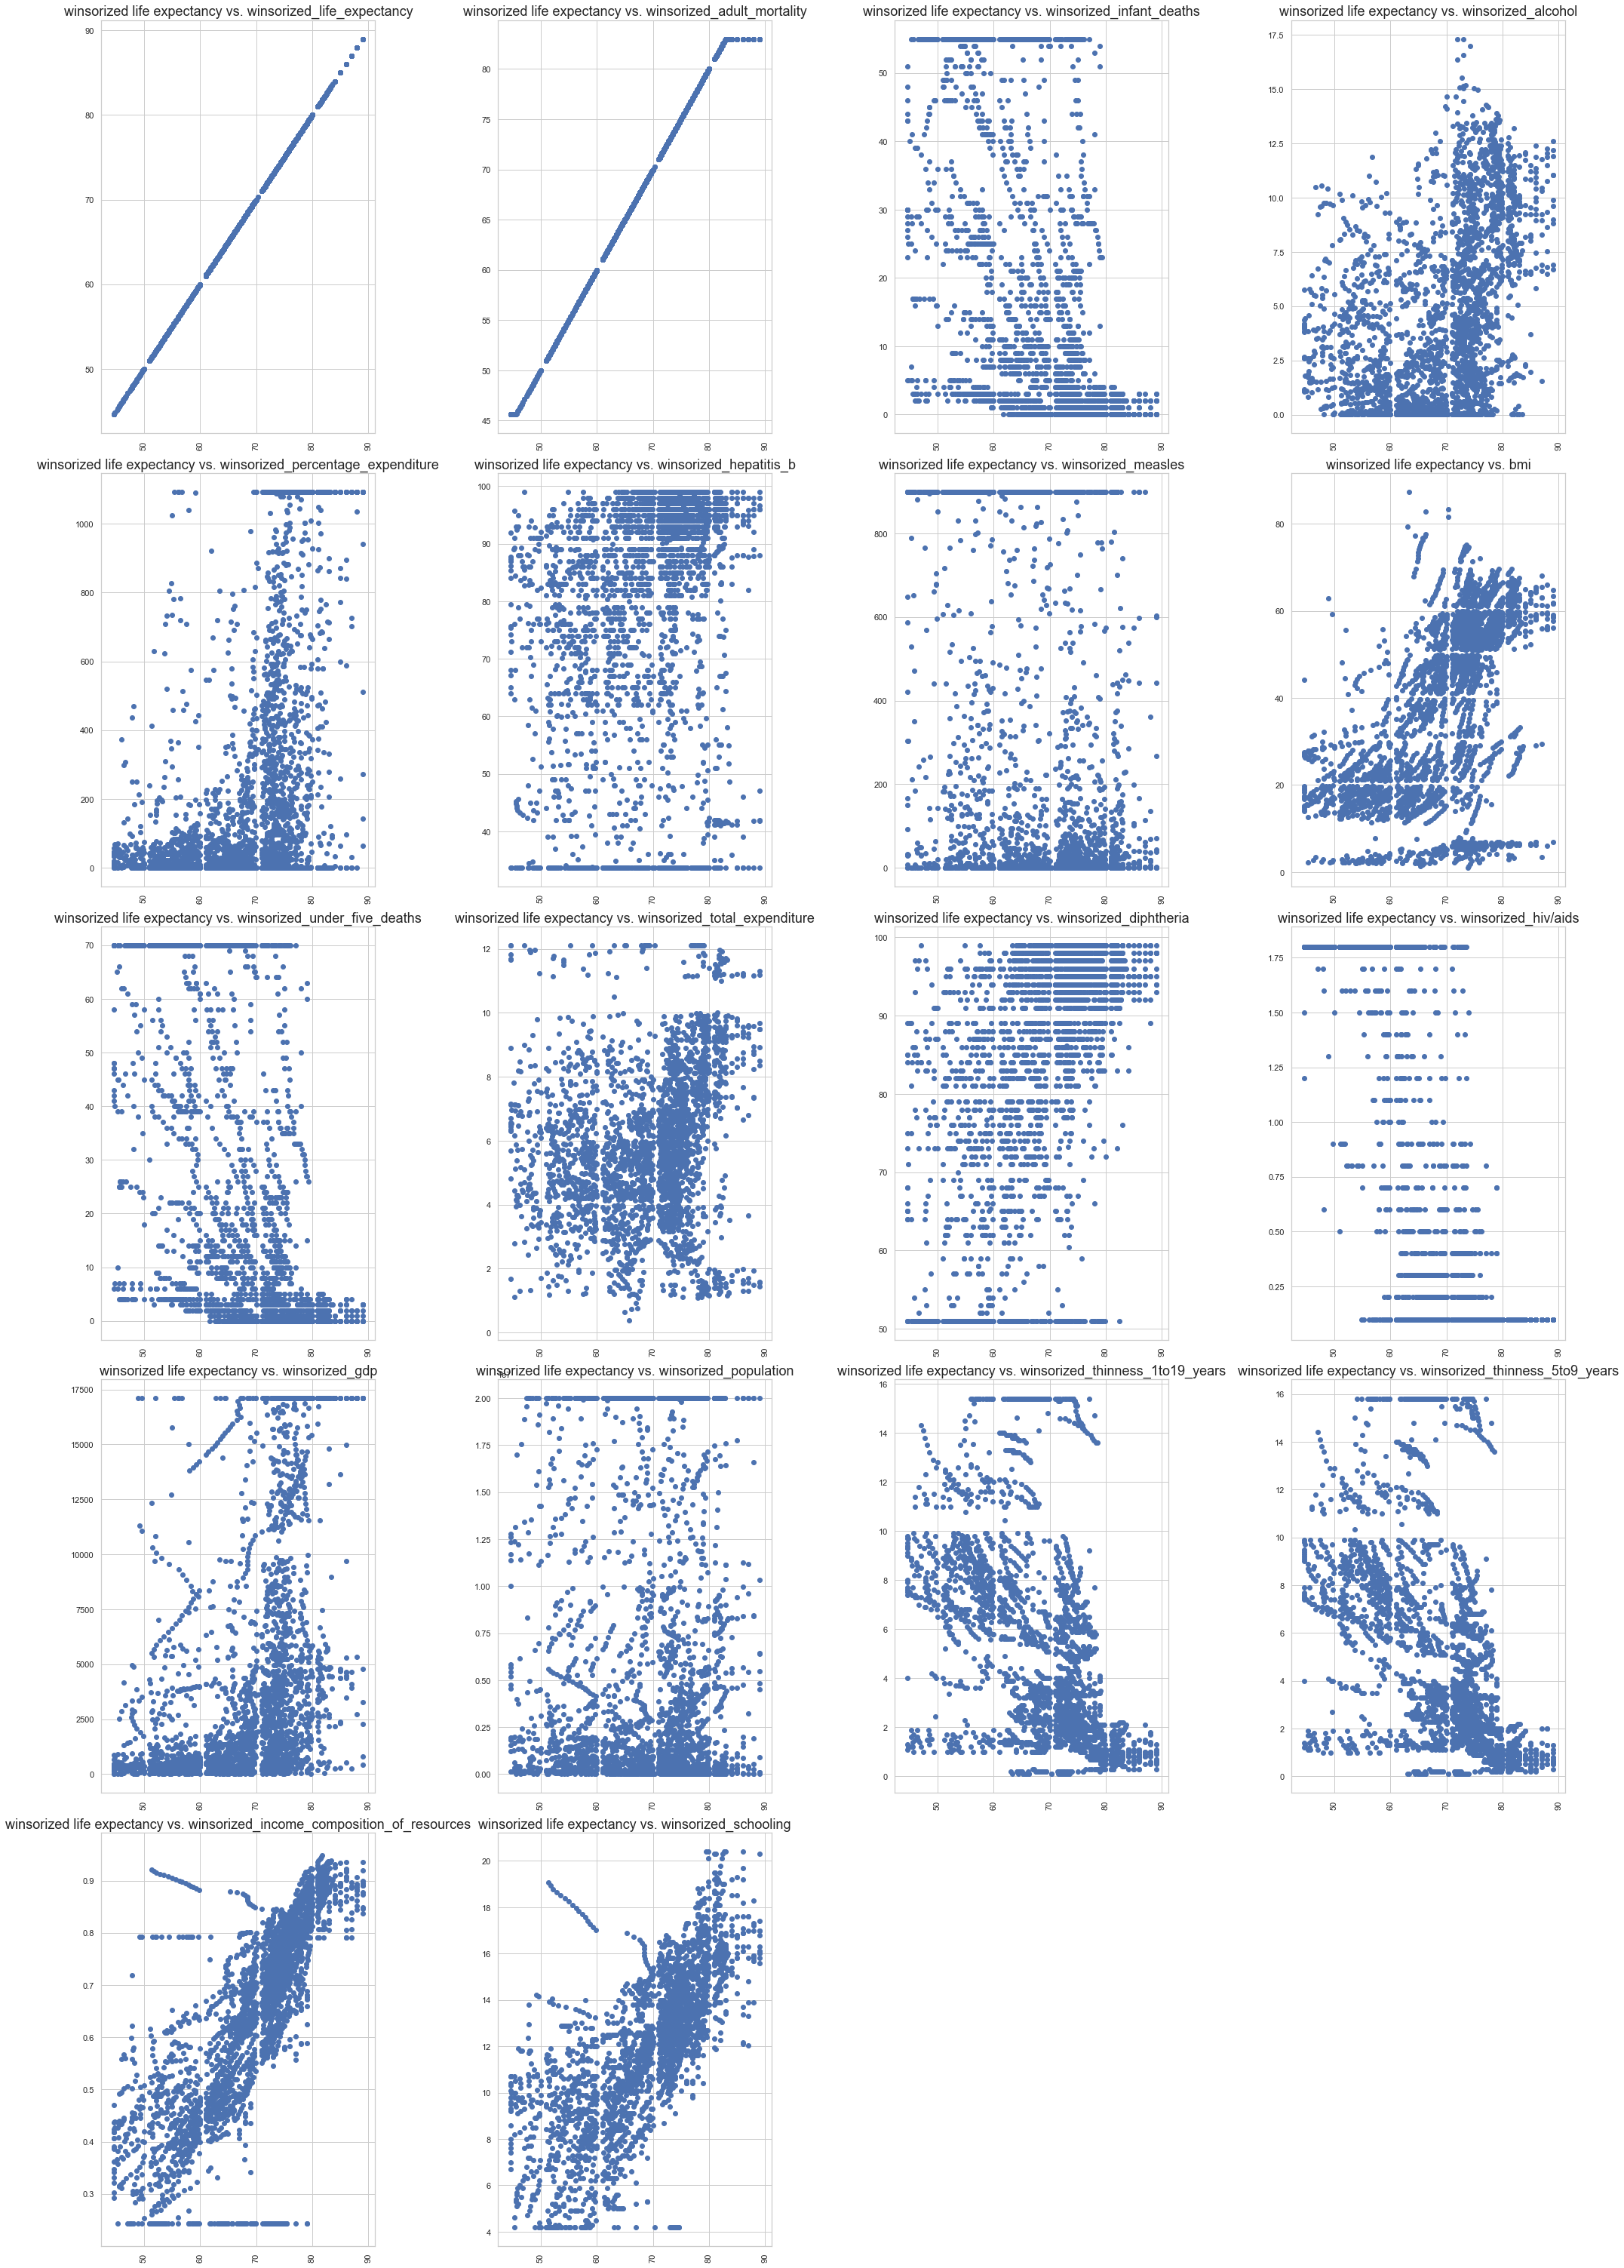

In [15]:
fig = plt.figure(figsize=(30,150))

for i, col in enumerate(winsorized_list):
    
    plt.subplot(len(winsorized_list), 4, i+1)
    plt.scatter(life_expectancy2['winsorized_life_expectancy'], life_expectancy2[col])
    plt.xticks(rotation='vertical')
    plt.title("winsorized life expectancy vs. {}".format(col), fontsize=18)
    
plt.tight_layout()
plt.show()

A couple of variables seem to have positive relationship with life expectancy. Like expenditure, schooling, composition of resources, percentage expenditure, and gdp. And we see negative relationship with both thinness variables. 

Looking at a heatmap of variable correlation to see which variables to use for feature engineering 

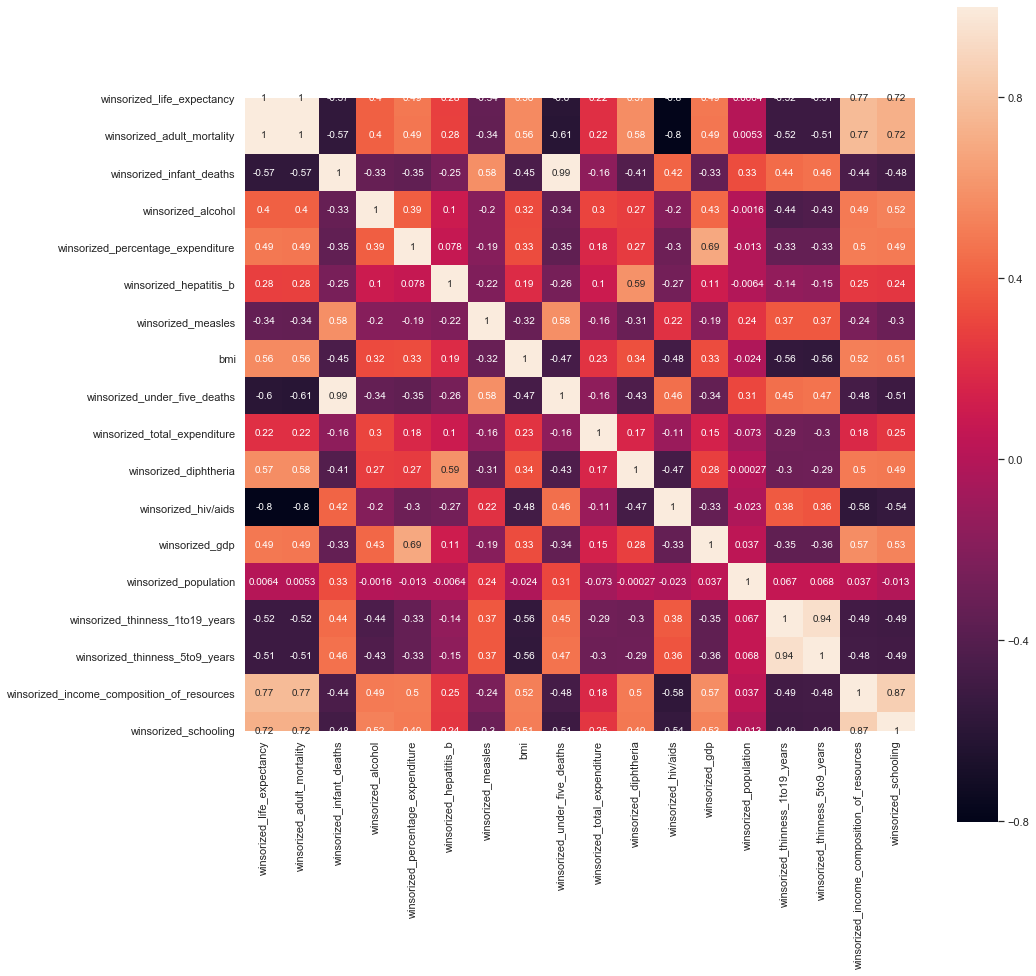

In [16]:
test_variables = pd.concat([life_expectancy2[winsorized_list]])
test_variables_heatmap = test_variables.corr()
plt.figure(figsize=(15,15))
ax = sns.heatmap(test_variables_heatmap, square=True, annot=True)

Short of normalizing all of the variables, I think that we can make a relatively strong case for making our final dataframe

hiv/aids has a negative relation with life expectancy while schooling and composition of resources both have a pretty positive relation. Since composition of resources and schooling each have a high correlation with our target variable of life expectancy, but both have an even higher correlation with each other, we will drop the schooling variable from the feature engineering stage.

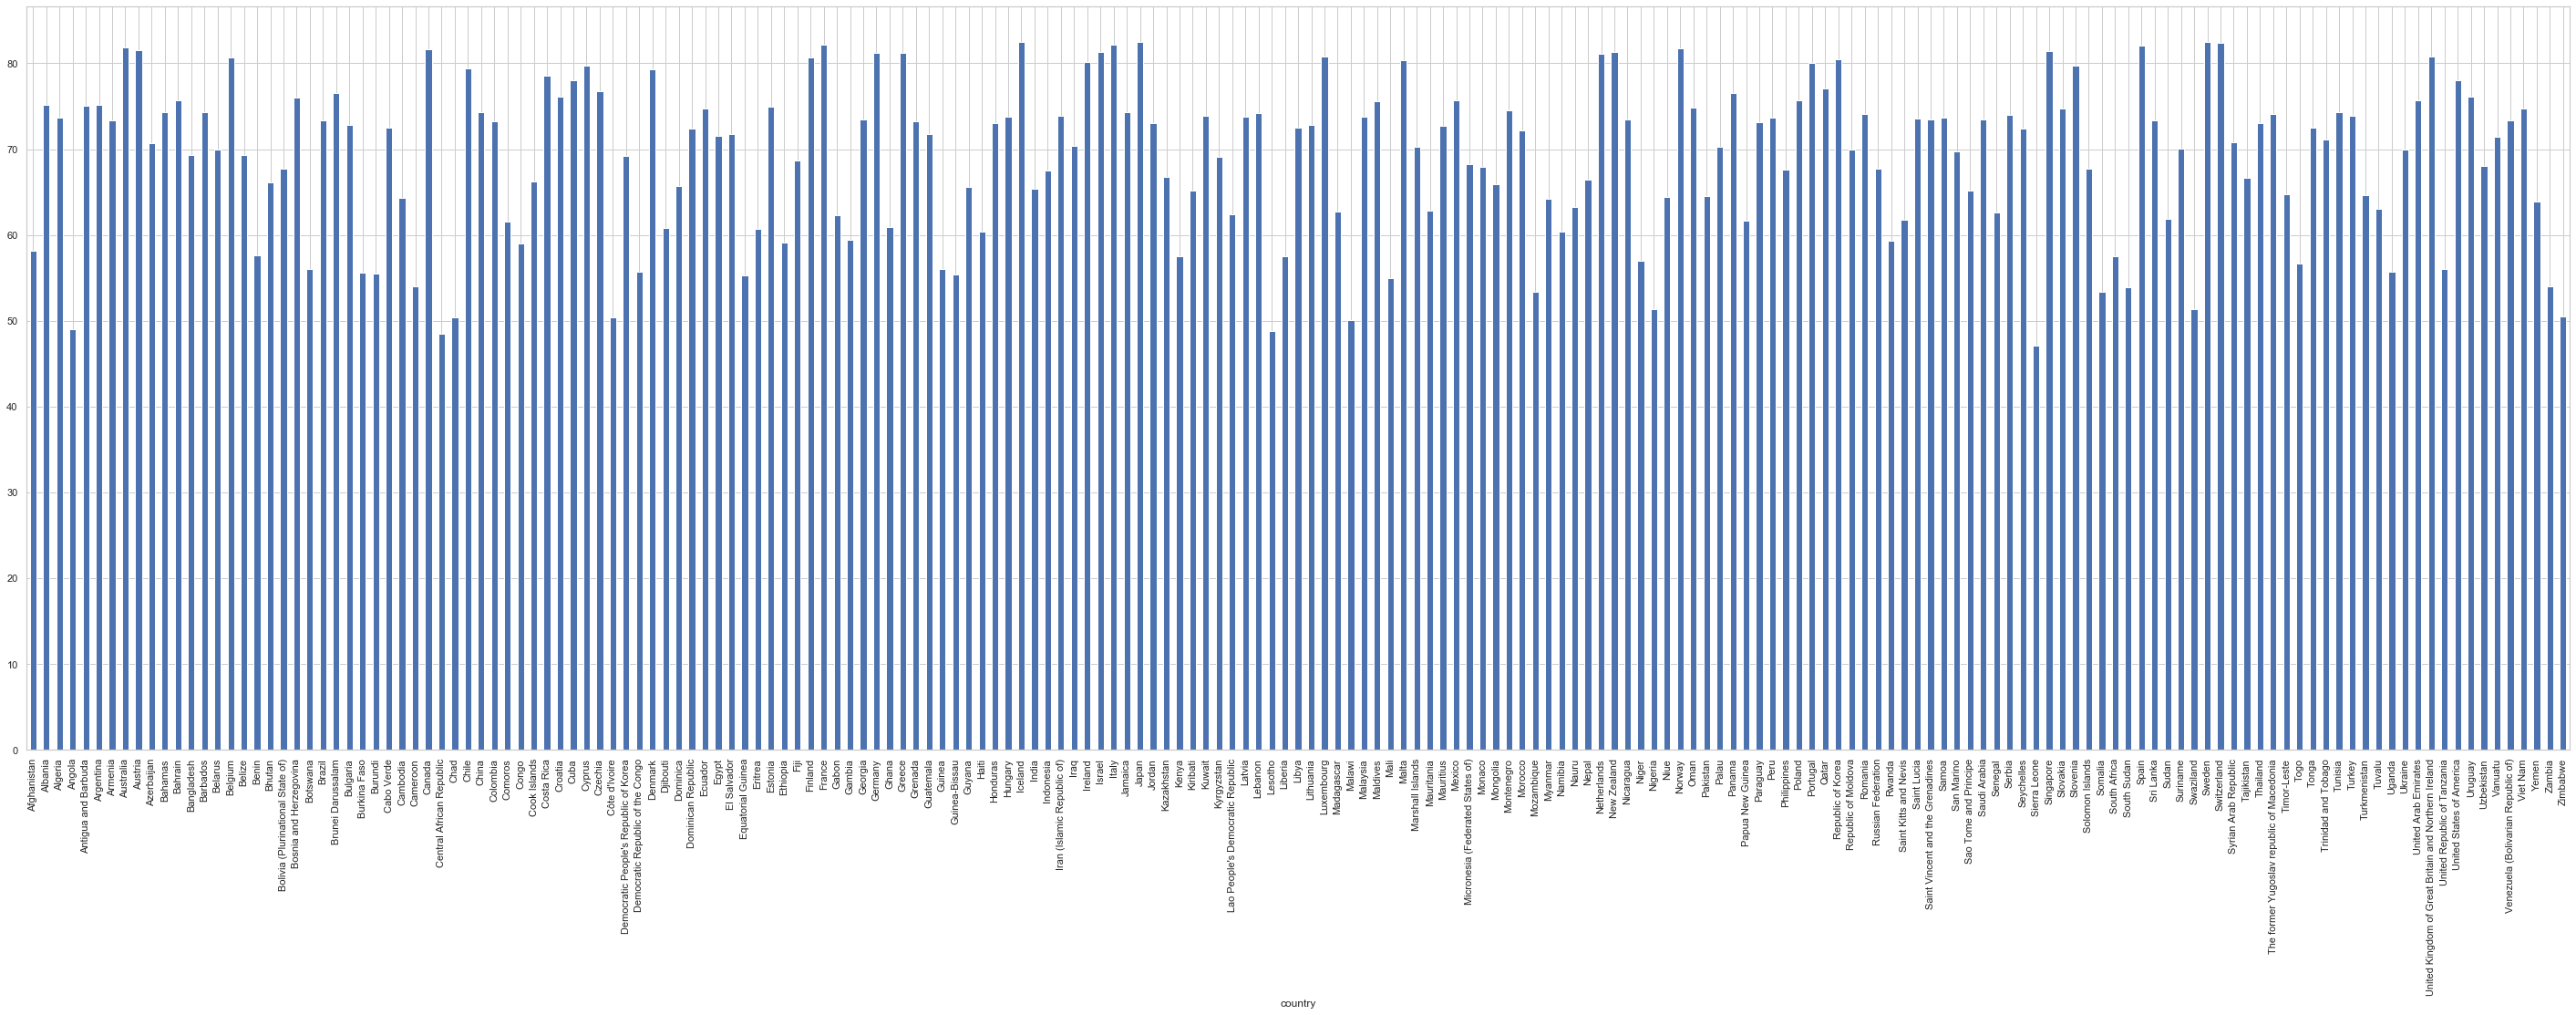

In [17]:
plt.figure(figsize=(50,15))

bar = life_expectancy2.groupby('country')['winsorized_life_expectancy'].mean()
bar.plot(kind='bar')

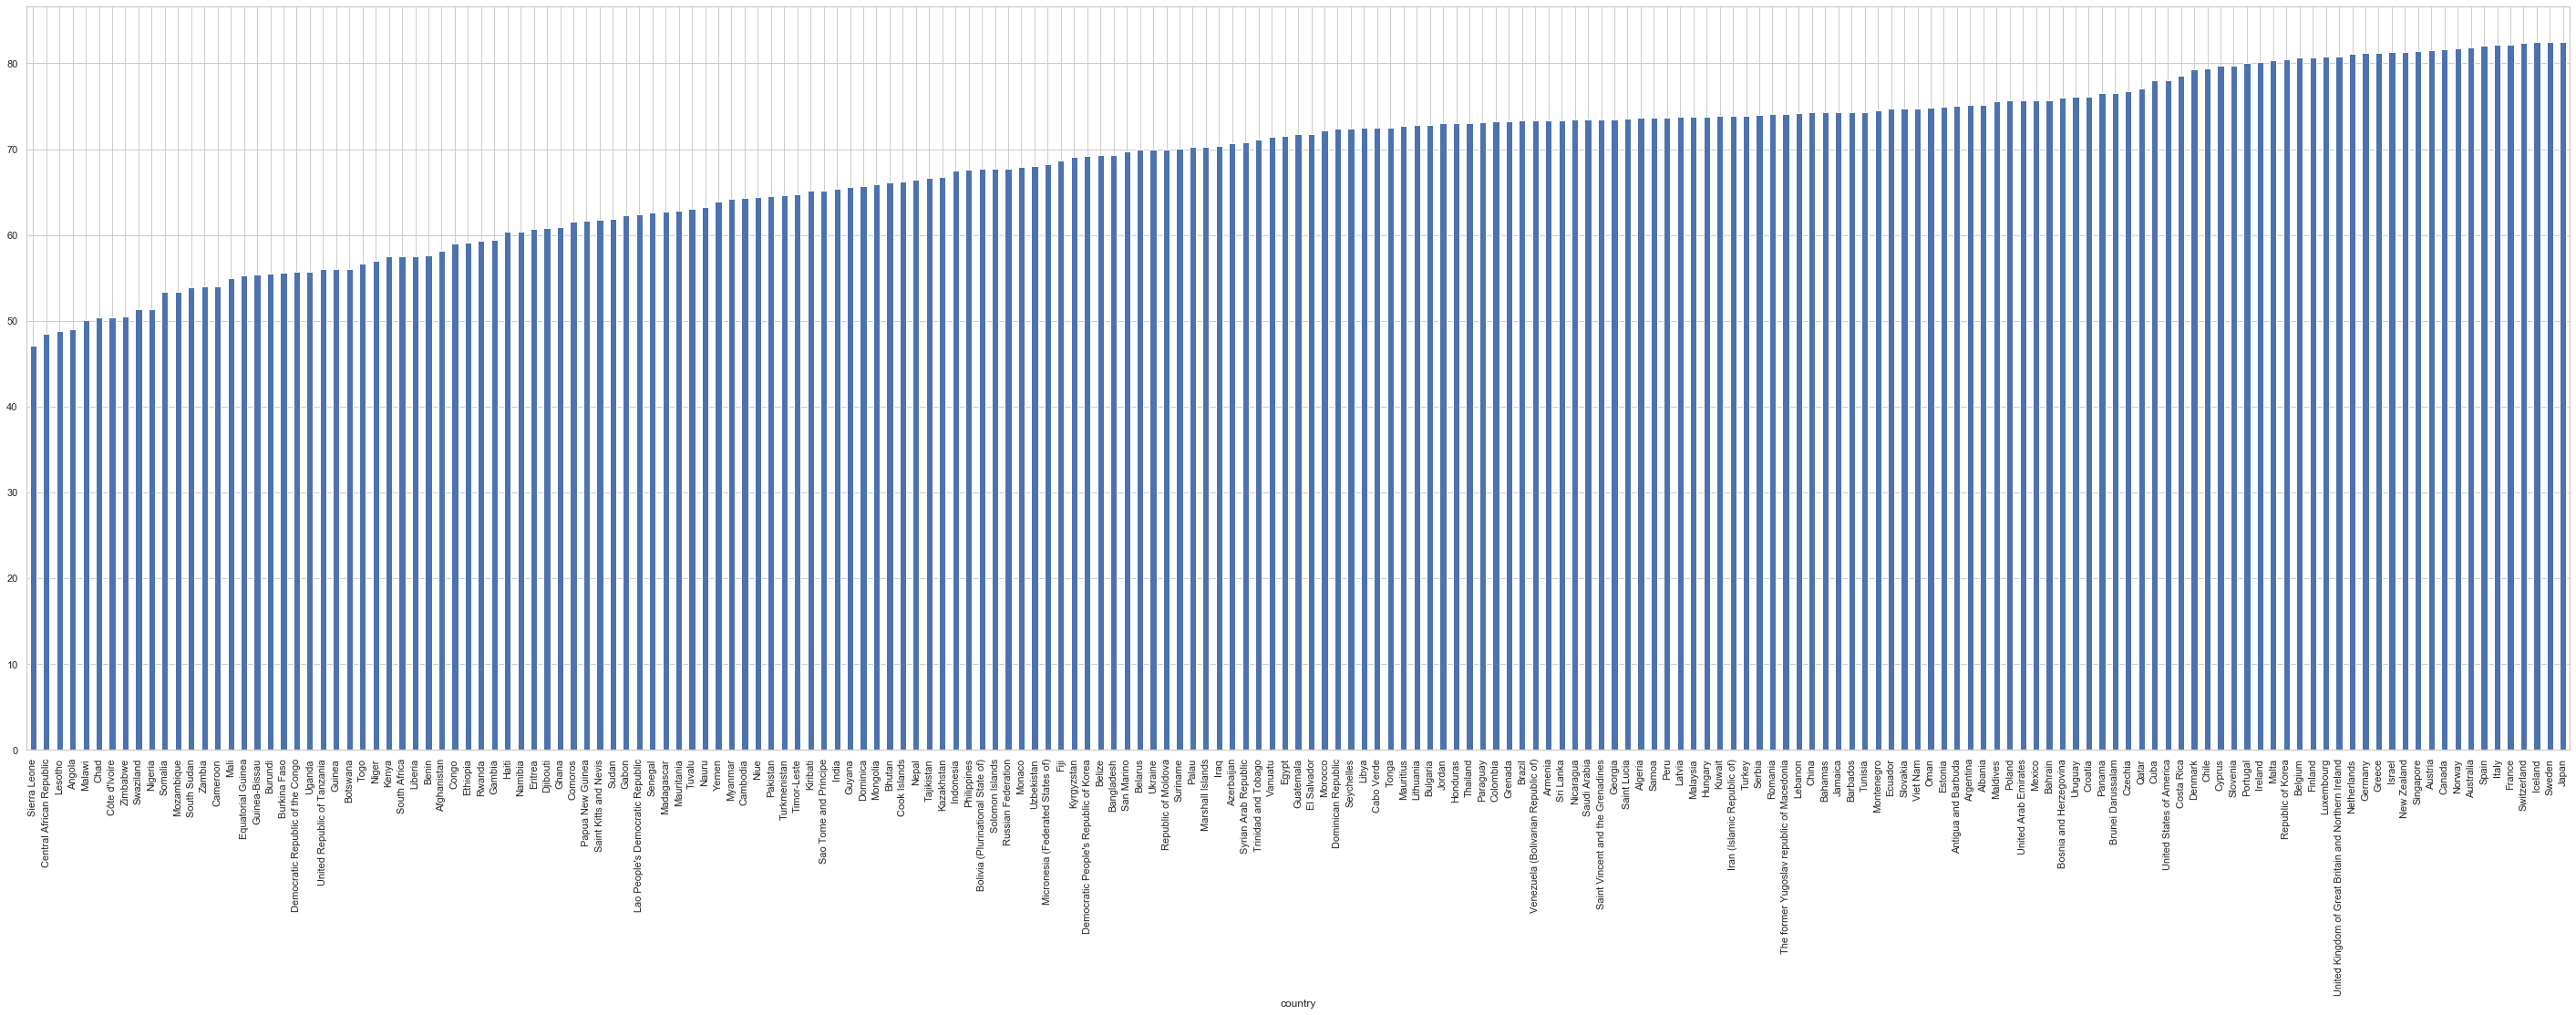

In [18]:
plt.figure(figsize=(50,15))

bar = life_expectancy2.groupby('country')['winsorized_life_expectancy'].mean().sort_values()

bar.plot(kind='bar')

Ttest_indResult(statistic=29.907692329971656, pvalue=8.614411136599398e-172)

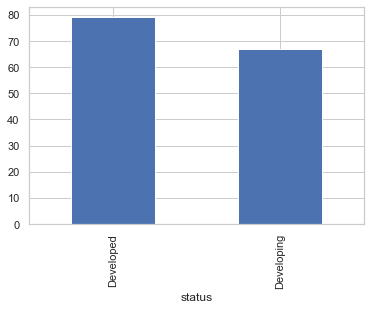

In [19]:
bar_status = life_expectancy2.groupby('status')['winsorized_life_expectancy'].mean()
bar_status.plot(kind='bar')
#looking at the status differences, it's easy to see the importance. Most likely a good 
#categorical variable for features
ttest_ind(life_expectancy2.loc[life_expectancy2['status'] == 'Developed', 'winsorized_life_expectancy'],
          life_expectancy2.loc[life_expectancy2['status'] == 'Developing', 'winsorized_life_expectancy'])

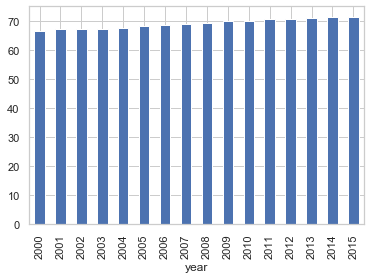

In [20]:
bar_year = life_expectancy2.groupby('year')['winsorized_life_expectancy'].mean()

bar_year.plot(kind='bar')

Looking at the ttest from before, there is a significant statistical difference between life expectancy of developed and developing countries. We also found that income composition of resources and schooling have high correlation with life expectancy, but because they have such high correlation with each other, I've decided to drop schooling from the feature engineering stage. HIV/AIDS has a very strong negative correlation with life expectancy so I've added it as well. Another variable that could work on this but I didn't include is the under five deaths.

1: Status 

2: winsorized income composition of resources 

3: winsorized hiv/aids 

The next step will be to concatenate our feature variables, with countries, year, and status but with dummy values.

In [21]:
feature_df = pd.concat([life_expectancy2['winsorized_income_composition_of_resources'],
                       life_expectancy2['winsorized_hiv/aids'],
                       pd.get_dummies(life_expectancy2['status'])], axis=1)


In [22]:
print(feature_df.head())

   winsorized_income_composition_of_resources  winsorized_hiv/aids  Developed  \
0                                       0.479                  0.1          0   
1                                       0.476                  0.1          0   
2                                       0.470                  0.1          0   
3                                       0.463                  0.1          0   
4                                       0.454                  0.1          0   

   Developing  
0           1  
1           1  
2           1  
3           1  
4           1  


Ultimately I chose to take on just a few variables that I thought to be significant. 